In [391]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('bbc-text.csv')


print(df.head())

        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


In [392]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['text']
y = df['category']

#list of text
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

tfidf = TfidfVectorizer(max_features=2000, stop_words='english')

# Learn the vocabulary and IDF weights from the training text (fit),
# then convert each training document into a TF-IDF numeric vector (transform).
X_train = tfidf.fit_transform(X_train_raw).toarray()
X_test = tfidf.transform(X_test_raw).toarray()


In [393]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Find the majority class in the training set
majority_class = y_train.value_counts().idxmax()
print(f"The majority class is: {majority_class}")

# Predict the majority class for all test samples
y_pred_simple = [majority_class] * len(y_test)

# Compute metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_simple):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_simple, average='weighted', zero_division=0):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_simple, average='weighted', zero_division=0):.4f}")

# Recall for the 'sport' class only
print(f"Recall (sport): {recall_score(y_test, y_pred_simple, labels=['sport'], average=None)[0]:.4f}")

The majority class is: sport
Accuracy: 0.2427
Precision (weighted): 0.0589
Recall (weighted): 0.2427
Recall (sport): 1.0000


In [394]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 1. Create a keyword dictionary for each category using TF-IDF
# We select the words with the highest importance scores for each class
tfidf_gen = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf_gen.fit_transform(X_train_raw)
words = np.array(tfidf_gen.get_feature_names_out())

category_dictionaries = {}

for cat in y_train.unique():
    # Find indices of documents belonging to the specific category
    cat_indices = np.where(y_train == cat)[0]

    # Calculate the mean TF-IDF score for each word in this category
    cat_means = np.mean(X_train_tfidf[cat_indices], axis=0).A1

    # Select the top 20 words with the highest mean scores
    top_indices = cat_means.argsort()[-20:]
    category_dictionaries[cat] = set(words[top_indices])

    # Log the top words for verification
    print(f"Top words for {cat}: {list(category_dictionaries[cat])[:5]}...")

# 2. Define a prediction function based on dictionary overlap
def predict_by_dictionary(text):
    # Convert text to lowercase and split into a set of words
    text_words = set(text.lower().split())
    scores = {}

    for cat, dict_words in category_dictionaries.items():
        # Count how many keywords from the category dictionary appear in the text
        scores[cat] = len(text_words.intersection(dict_words))

    # Return the category with the highest overlap count
    return max(scores, key=scores.get)

# 3. Evaluate the model on the test set and calculate metrics (Section 11)
y_pred_dict = X_test_raw.apply(predict_by_dictionary)

print(f"\nAccuracy: {accuracy_score(y_test, y_pred_dict):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred_dict, average='weighted', zero_division=0):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred_dict, average='weighted', zero_division=0):.4f}")

Top words for tech: ['microsoft', 'online', 'broadband', 'software', 'net']...
Top words for politics: ['brown', 'minister', 'lord', 'howard', 'government']...
Top words for sport: ['players', 'world', 'coach', 'injury', 'team']...
Top words for business: ['oil', 'economy', 'market', 'year', 'government']...
Top words for entertainment: ['oscar', 'tv', 'film', 'band', 'actress']...

Accuracy: 0.8831
Precision (weighted): 0.8861
Recall (weighted): 0.8831


In [395]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Setting a seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior in some operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 1. Prepare Tensors
# Convert TF-IDF matrices (X_train, X_test) to float32 tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Convert labels (y) to numerical values (0 to 4)
category_map = {cat: i for i, cat in enumerate(y_train.unique())}
y_train_num = y_train.map(category_map).values
y_test_num = y_test.map(category_map).values

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train_num, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_num, dtype=torch.long)

In [396]:
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftmaxClassifier, self).__init__()
        # Single linear layer (Softmax/Logistic Regression)
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # We return logits (raw scores).
        # Note: CrossEntropyLoss in PyTorch applies Softmax automatically.
        return self.linear(x)

# Initialize model
input_dim = X_train.shape[1] # Number of features (TF-IDF words)
output_dim = 5               # Number of BBC categories
model = SoftmaxClassifier(input_dim, output_dim)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Training Loop with Text Output and History Tracking for the Graph

epochs = 300
history_softmax = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': [],
    'train_err': [], 'test_err': []
}

print(f"{'Epoch':<10} | {'Loss':<10} | {'Train Error':<12} | {'Test Error':<12}")
print("-" * 55)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)

    # Backward pass
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)

        # Calculations for metrics
        _, train_pred = torch.max(train_outputs, 1)
        train_acc = (train_pred == y_train_tensor).sum().item() / y_train_tensor.size(0)

        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test_tensor).sum().item() / y_test_tensor.size(0)

        train_err = 1 - train_acc
        test_err = 1 - test_acc

    # Save to history
    history_softmax['train_loss'].append(train_loss.item())
    history_softmax['test_loss'].append(test_loss.item())
    history_softmax['train_acc'].append(train_acc)
    history_softmax['test_acc'].append(test_acc)
    history_softmax['train_err'].append(train_err)
    history_softmax['test_err'].append(test_err)


    print(f"{epoch+1:<10} | {train_loss.item():<10.4f} | {train_err:<12.4f} | {test_err:<12.4f}")



Epoch      | Loss       | Train Error  | Test Error  
-------------------------------------------------------
1          | 1.6093     | 0.8444       | 0.1281      
2          | 1.5534     | 0.0927       | 0.0989      
3          | 1.4989     | 0.0770       | 0.0944      
4          | 1.4457     | 0.0764       | 0.0854      
5          | 1.3939     | 0.0758       | 0.0876      
6          | 1.3435     | 0.0730       | 0.0809      
7          | 1.2944     | 0.0708       | 0.0787      
8          | 1.2468     | 0.0646       | 0.0719      
9          | 1.2005     | 0.0579       | 0.0697      
10         | 1.1557     | 0.0539       | 0.0652      
11         | 1.1122     | 0.0489       | 0.0652      
12         | 1.0701     | 0.0449       | 0.0629      
13         | 1.0295     | 0.0427       | 0.0584      
14         | 0.9902     | 0.0393       | 0.0517      
15         | 0.9523     | 0.0371       | 0.0517      
16         | 0.9158     | 0.0348       | 0.0449      
17         | 0.8807     | 

In [397]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


model.eval()

with torch.no_grad():

    test_outputs = model(X_test_tensor)
    _, y_pred = torch.max(test_outputs, 1)


    y_true_np = y_test_tensor.numpy()
    y_pred_np = y_pred.numpy()

final_acc = accuracy_score(y_true_np, y_pred_np)
final_precision = precision_score(y_true_np, y_pred_np, average='weighted')
final_recall = recall_score(y_true_np, y_pred_np, average='weighted')


print(f"FINAL MODEL RESULTS:")
print(f"Accuracy:  {final_acc:.4f} ({final_acc*100:.2f}%)")
print(f"Precision: {final_precision:.4f}")
print(f"Recall:    {final_recall:.4f}")


FINAL MODEL RESULTS:
Accuracy:  0.9775 (97.75%)
Precision: 0.9776
Recall:    0.9775


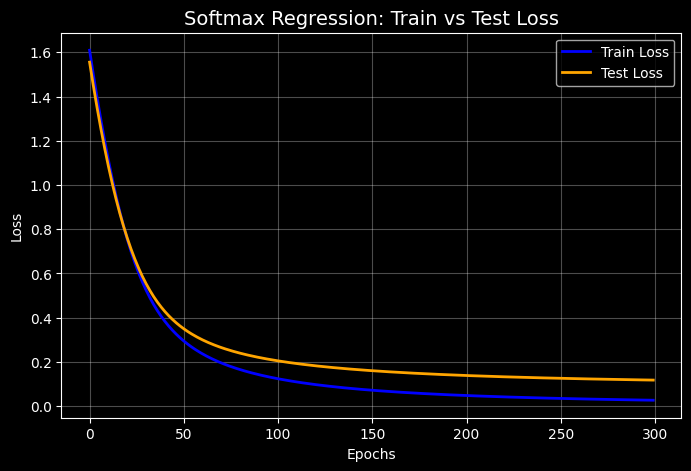

In [398]:
import matplotlib.pyplot as plt

# --- Softmax: Train Loss vs Test Loss ---
plt.figure(figsize=(8, 5))
plt.plot(history_softmax['train_loss'], label='Train Loss', color='blue', lw=2)
plt.plot(history_softmax['test_loss'], label='Test Loss', color='orange', lw=2)
plt.title('Softmax Regression: Train vs Test Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

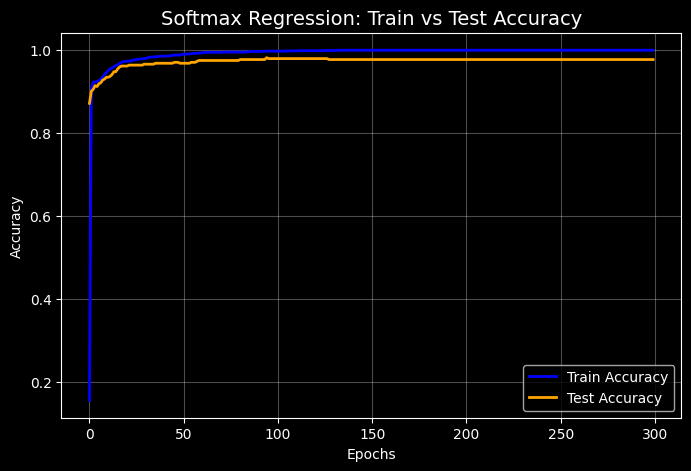

In [399]:
# --- Softmax: Train Accuracy vs Test Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(history_softmax['train_acc'], label='Train Accuracy', color='blue', lw=2)
plt.plot(history_softmax['test_acc'], label='Test Accuracy', color='orange', lw=2)
plt.title('Softmax Regression: Train vs Test Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [400]:
import torch
import torch.nn as nn
import torch.optim as optim


class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPClassifier, self).__init__()
        # First hidden layer: Input -> 100 neurons
        self.hidden1 = nn.Linear(input_dim, 100)
        # Second hidden layer: 100 -> 50 neurons
        self.hidden2 = nn.Linear(100, 50)

        self.dropout = nn.Dropout(0.3)
        # Output layer: 50 -> Categories (5)
        self.linear = nn.Linear(50, output_dim)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = self.dropout(x)
        x = torch.relu(self.hidden2(x))
        x = self.dropout(x)
        return self.linear(x)

# 2. Initialize the model
input_dim = X_train.shape[1]
output_dim = 5
model = MLPClassifier(input_dim, output_dim)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 3. Training Loop with History tracking
epochs = 150
history_mlp_new = {
    'train_loss': [], 'test_loss': [],
    'train_acc': [], 'test_acc': [],
    'train_err': [], 'test_err': []
}


print(f"{'Epoch':<10} | {'Loss':<10} | {'Train Error':<12} | {'Test Error':<12}")
print("-" * 55)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    train_outputs = model(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)

    # Backward pass
    train_loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)


        _, train_pred = torch.max(train_outputs, 1)
        train_acc = (train_pred == y_train_tensor).sum().item() / y_train_tensor.size(0)

        _, test_pred = torch.max(test_outputs, 1)
        test_acc = (test_pred == y_test_tensor).sum().item() / y_test_tensor.size(0)

        train_err = 1 - train_acc
        test_err = 1 - test_acc

    # שמירה להיסטוריה
    history_mlp_new['train_loss'].append(train_loss.item())
    history_mlp_new['test_loss'].append(test_loss.item())
    history_mlp_new['train_acc'].append(train_acc)
    history_mlp_new['test_acc'].append(test_acc)
    history_mlp_new['train_err'].append(train_err)
    history_mlp_new['test_err'].append(test_err)


    print(f"{epoch+1:<10} | {train_loss.item():<10.4f} | {train_err:<12.4f} | {test_err:<12.4f}")

Epoch      | Loss       | Train Error  | Test Error  
-------------------------------------------------------
1          | 1.6104     | 0.8213       | 0.8472      
2          | 1.6089     | 0.8213       | 0.8472      
3          | 1.6063     | 0.8213       | 0.8472      
4          | 1.6030     | 0.8185       | 0.8472      
5          | 1.5997     | 0.8112       | 0.8472      
6          | 1.5961     | 0.7837       | 0.7978      
7          | 1.5922     | 0.7320       | 0.6607      
8          | 1.5870     | 0.6815       | 0.6090      
9          | 1.5817     | 0.6635       | 0.6000      
10         | 1.5756     | 0.6230       | 0.5910      
11         | 1.5704     | 0.5994       | 0.5551      
12         | 1.5636     | 0.5421       | 0.4494      
13         | 1.5562     | 0.4972       | 0.3978      
14         | 1.5486     | 0.4629       | 0.3933      
15         | 1.5412     | 0.4404       | 0.3730      
16         | 1.5302     | 0.4253       | 0.3663      
17         | 1.5221     | 

In [404]:
# # ----4 HIDDEN LAYERS------
#
# class MLPClassifier(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(MLPClassifier, self).__init__()
#         # Layer 1: Input to 512 neurons
#         self.hidden1 = nn.Linear(input_dim, 512)
#         # Layer 2: 512 to 256 neurons
#         self.hidden2 = nn.Linear(512, 256)
#         # Layer 3: 256 to 128 neurons
#         self.hidden3 = nn.Linear(256, 128)
#         # Layer 4: 128 to 64 neurons
#         self.hidden4 = nn.Linear(128, 64)
#
#         # Dropout to prevent overfitting (common in deep architectures) [cite: 116]
#         self.dropout = nn.Dropout(0.3)
#         # Output layer
#         self.output = nn.Linear(64, output_dim)
#
#     def forward(self, x):
#         # Activation function ReLU is used between layers [cite: 109, 110]
#         x = torch.relu(self.hidden1(x))
#         x = self.dropout(x)
#
#         x = torch.relu(self.hidden2(x))
#         x = self.dropout(x)
#
#         x = torch.relu(self.hidden3(x))
#         x = self.dropout(x)
#
#         x = torch.relu(self.hidden4(x))
#         x = self.dropout(x)
#
#         return self.output(x)
#
# # 2. Initialize the model
# input_dim = X_train.shape[1]
# output_dim = 5
# model = MLPClassifier(input_dim, output_dim)
#
# # Loss and Optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
#
# # 3. Training Loop with History tracking
# epochs = 300
# history_mlp_new = {
#     'train_loss': [], 'test_loss': [],
#     'train_acc': [], 'test_acc': [],
#     'train_err': [], 'test_err': []
# }
#
#
# print(f"{'Epoch':<10} | {'Loss':<10} | {'Train Error':<12} | {'Test Error':<12}")
# print("-" * 55)
#
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#
#     # Forward pass
#     train_outputs = model(X_train_tensor)
#     train_loss = criterion(train_outputs, y_train_tensor)
#
#     # Backward pass
#     train_loss.backward()
#     optimizer.step()
#
#     # Evaluation
#     model.eval()
#     with torch.no_grad():
#         test_outputs = model(X_test_tensor)
#         test_loss = criterion(test_outputs, y_test_tensor)
#
#
#         _, train_pred = torch.max(train_outputs, 1)
#         train_acc = (train_pred == y_train_tensor).sum().item() / y_train_tensor.size(0)
#
#         _, test_pred = torch.max(test_outputs, 1)
#         test_acc = (test_pred == y_test_tensor).sum().item() / y_test_tensor.size(0)
#
#         train_err = 1 - train_acc
#         test_err = 1 - test_acc
#
#
#     history_mlp_new['train_loss'].append(train_loss.item())
#     history_mlp_new['test_loss'].append(test_loss.item())
#     history_mlp_new['train_acc'].append(train_acc)
#     history_mlp_new['test_acc'].append(test_acc)
#     history_mlp_new['train_err'].append(train_err)
#     history_mlp_new['test_err'].append(test_err)
#
#
#     print(f"{epoch+1:<10} | {train_loss.item():<10.4f} | {train_err:<12.4f} | {test_err:<12.4f}")
#

Epoch      | Loss       | Train Error  | Test Error  
-------------------------------------------------------
1          | 1.6186     | 0.8208       | 0.8472      
2          | 1.6165     | 0.8180       | 0.8472      
3          | 1.6141     | 0.8157       | 0.8472      
4          | 1.6109     | 0.8084       | 0.8472      
5          | 1.6067     | 0.7854       | 0.7708      
6          | 1.6013     | 0.7562       | 0.6607      
7          | 1.5948     | 0.6854       | 0.4539      
8          | 1.5849     | 0.5848       | 0.4404      
9          | 1.5732     | 0.4899       | 0.3101      
10         | 1.5570     | 0.4045       | 0.2270      
11         | 1.5379     | 0.3719       | 0.3124      
12         | 1.5100     | 0.3191       | 0.2989      
13         | 1.4759     | 0.3326       | 0.3191      
14         | 1.4390     | 0.3697       | 0.3371      
15         | 1.3881     | 0.3820       | 0.3551      
16         | 1.3234     | 0.4079       | 0.3708      
17         | 1.2536     | 

In [401]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    # Get predictions for the entire test set
    final_outputs = model(X_test_tensor)
    _, final_pred = torch.max(final_outputs, 1)

    # Convert tensors back to numpy for evaluation metrics
    y_true = y_test_tensor.numpy()
    y_pred = final_pred.numpy()

# Calculate final metrics (Weighted averages are best for multi-class)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')


print(f"FINAL MLP MODEL RESULTS")

print(f"Final Test Accuracy:  {accuracy:.4f}")
print(f"Final Test Precision: {precision:.4f}")
print(f"Final Test Recall:    {recall:.4f}")


FINAL MLP MODEL RESULTS
Final Test Accuracy:  0.9820
Final Test Precision: 0.9821
Final Test Recall:    0.9820


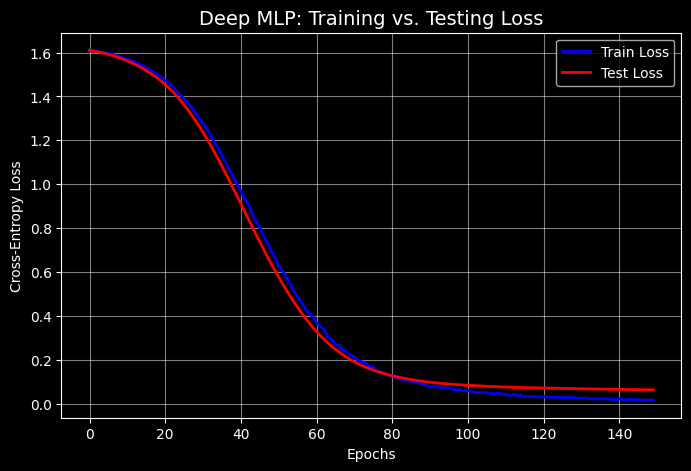

In [402]:
import matplotlib.pyplot as plt

# --- Plot: Training vs Testing Loss ---
plt.figure(figsize=(8, 5))
plt.plot(history_mlp_new['train_loss'], label='Train Loss', color='blue', lw=2)
plt.plot(history_mlp_new['test_loss'], label='Test Loss', color='red', lw=2)

plt.title('Deep MLP: Training vs. Testing Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

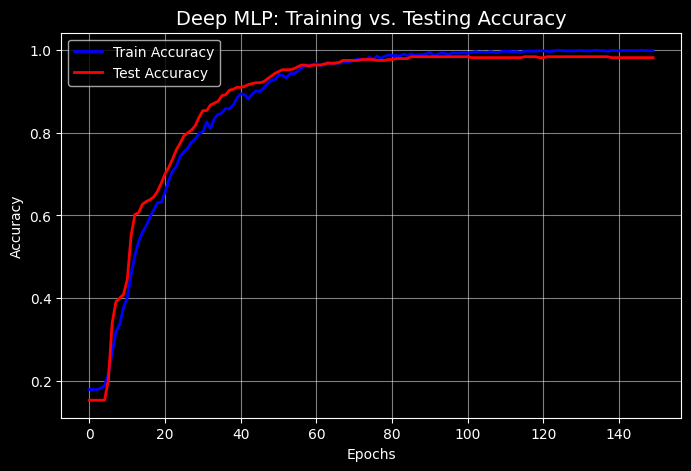

In [403]:
# --- Plot: Training vs Testing Accuracy ---
plt.figure(figsize=(8, 5))

plt.plot(history_mlp_new['train_acc'], label='Train Accuracy', color='blue', lw=2)
plt.plot(history_mlp_new['test_acc'], label='Test Accuracy', color='red', lw=2)

plt.title('Deep MLP: Training vs. Testing Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()